In [3]:
%pylab inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatma

Populating the interactive namespace from numpy and matplotlib


In [4]:
import os, sys
caffe_root = os.environ['HOME'] + "/progs/caffe/"
sys.path.append(caffe_root+"python")
import caffe

In [7]:
# Download data
os.chdir(caffe_root)
!data/mnist/get_mnist.sh
# Prepare data
!examples/mnist/create_mnist.sh
# back to examples
os.chdir('examples')

Downloading...
Creating lmdb...
I0512 08:37:29.607224 1994280960 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I0512 08:37:29.608045 1994280960 convert_mnist_data.cpp:88] A total of 60000 items.
I0512 08:37:29.608057 1994280960 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0512 08:37:29.887678 1994280960 convert_mnist_data.cpp:108] Processed 60000 files.
I0512 08:37:29.904150 1994280960 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I0512 08:37:29.904989 1994280960 convert_mnist_data.cpp:88] A total of 10000 items.
I0512 08:37:29.905006 1994280960 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I0512 08:37:29.956907 1994280960 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


### Set up
2 externa files will be needed:
- the net prototxt - net architecture, and pointing to train/test data
- the solver prototxt - defining learning parametes

The network expects to read from pregenerated LMDBs, but reading directly from np.ndarray is also possible using MemoryDataLayer.

In [10]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('mnist/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_train_lmdb', 64)))
    
with open('mnist/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('mnist/mnist_test_lmdb', 100)))

print "This has written the net to disk in a human-readable serialization file format using Google's protobuf library. "
print "You can read/write/modify this description directly."

This has written the net to disk in a human-readable serialization file format using Google's protobuf library. 
You can read/write/modify this description directly.


In [11]:
!cat mnist/lenet_auto_train.prototxt

layer {
  name: "data"
  type: "Data"
  top: "data"
  top: "label"
  transform_param {
    scale: 0.00392156862745
  }
  data_param {
    source: "mnist/mnist_train_lmdb"
    batch_size: 64
    backend: LMDB
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  convolution_param {
    num_output: 20
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "pool1"
  top: "conv2"
  convolution_param {
    num_output: 50
    kernel_size: 5
    weight_filler {
      type: "xavier"
    }
  }
}
layer {
  name: "pool2"
  type: "Pooling"
  bottom: "conv2"
  top: "pool2"
  pooling_param {
    pool: MAX
    kernel_size: 2
    stride: 2
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "pool2"
  top: "fc1"
  inner_product_param {
    num_out

In [13]:
print "Learning parameters below: using SGD with momentum, weight decay, and a specific learning rate schedule."
print ""
!cat mnist/lenet_auto_solver.prototxt

Learning parameters below: using SGD with momentum, weight decay, and a specific learning rate schedule.

# The train/test net protocol buffer definition
train_net: "mnist/lenet_auto_train.prototxt"
test_net: "mnist/lenet_auto_test.prototxt"
# test_iter specifies how many forward passes the test should carry out.
# In the case of MNIST, we have test batch size 100 and 100 test iterations,
# covering the full 10,000 testing images.
test_iter: 100
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.01
momentum: 0.9
weight_decay: 0.0005
# The learning rate policy
lr_policy: "inv"
gamma: 0.0001
power: 0.75
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 10000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "mnist/lenet"


#### 3. Loading and checking the solver


In [14]:
caffe.set_mode_cpu()
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

In [15]:
print "Info on intermediate features (blobs) and parameters"
[(k,v.data.shape) for k,v in solver.net.blobs.items()]

Info on intermediate features (blobs) and parameters


[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [16]:
[(k,v[0].data.shape) for k,v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

In [17]:
print "Let's check that everything is loaded as we expect."
print "Checking that a forward pass contains/generates the data."
solver.net.forward()
solver.test_nets[0].forward()

Let's check that everything is loaded as we expect.
Checking that a forward pass contains/generates the data.


{'loss': array(2.3404128551483154, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


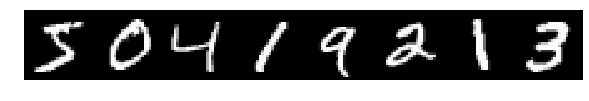

In [18]:
# we use a little trick to tile the first eight images
imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


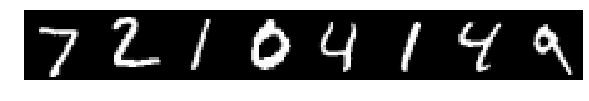

In [19]:
imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

#### 4. Stepping the Solver